In [196]:
import io
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from PIL import Image
import base64

from openai.types.chat.chat_completion import ChatCompletion
from openai.types.beta.threads import ImageFileContentBlock

sys.path.append(str(Path(".").resolve().parent))

from config.openai_client import client

In [2]:
def show_json(obj):
    display(json.loads(obj.model_dump_json()))

# Простой запрос в Chat

Дока для API: https://platform.openai.com/docs/api-reference/chat

In [3]:
text: str = "What is this 'ML'?"
response: ChatCompletion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "user", "content": text}],
    max_tokens=1024,
    temperature=0.5,
    # logprobs=True,
)

In [4]:
response.choices[0].message.content

'ML stands for machine learning, which is a field of artificial intelligence that focuses on the development of algorithms and models that can learn from and make predictions or decisions based on data. Machine learning algorithms are designed to analyze and interpret large amounts of data in order to identify patterns and make predictions without being explicitly programmed to do so.'

# Возможность обращаться к кастомным вспомогательным функциям

In [4]:
tools = [
  {
    "type": "function",
    "function": {
      "name": "get_current_weather",
      "description": "Get the current weather in a given location",
      "parameters": {
        "type": "object",
        "properties": {
          "location": {
            "type": "string",
            "description": "The city and state, e.g. San Francisco, CA",
          },
          "unit": {"type": "string", "enum": ["celsius", "fahrenheit"]},
        },
        "required": ["location", "unit"],
      },
    }
  }
]
messages = [{"role": "user", "content": "What's the weather like in Moscow today?"}]
completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=messages,
  tools=tools,
  tool_choice="auto"
)

print(completion)


ChatCompletion(id='chatcmpl-9S8kULJHXeF7iGasrCtGBJ8U7RvLF', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_SDl1hpegqRut9dZgNyrZxPyQ', function=Function(arguments='{"location":"Moscow","unit":"celsius"}', name='get_current_weather'), type='function')]))], created=1716493842, model='gpt-3.5-turbo-0125', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=21, prompt_tokens=83, total_tokens=104))


In [5]:
completion.choices[0].message

ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_SDl1hpegqRut9dZgNyrZxPyQ', function=Function(arguments='{"location":"Moscow","unit":"celsius"}', name='get_current_weather'), type='function')])

In [6]:
completion.choices[0].message.tool_calls[0].function

Function(arguments='{"location":"Moscow","unit":"celsius"}', name='get_current_weather')

# Code interpreter

In [207]:
stream_dataset = io.BytesIO()
df: pd.DataFrame = sns.load_dataset('titanic')
df.to_csv(stream_dataset, mode="wb")
stream_dataset.seek(0)

0

In [208]:
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [209]:
dataset_file = client.files.create(
  file=stream_dataset,
  purpose="assistants"
)
dataset_file

FileObject(id='file-2matvEQQUjeZbvuoKUMnDiZc', bytes=60473, created_at=1716555237, filename='upload', object='file', purpose='assistants', status='processed', status_details=None)

In [210]:
thread = client.beta.threads.create()

In [211]:
message = client.beta.threads.messages.create(
  thread_id=thread.id,
  role="user",
  content="Target: 'survived'. How it connected with feature 'age'? Plot pairplot graph for them.",
  # attachments=[{"file_id": dataset_file.id, "tools": [{"type": "code_interpreter"}]}],
)

In [212]:
features_charts_painter = client.beta.assistants.create(
  instructions="""You are an excellent senior Data Scientist with 10 years of experience. 
  You write and run code to describe connection between features and target, when you get table with data.
  
  If you create plot, save it  them in base64 format as text saved in separate txt file. Use for it separate message and don't truncate base64 code!
  """,
  # If you create plot, send them in base64 format as text saved in separate txt file. Use for it separate message and don't truncate base64 code!
  # If you create plot, add url for this image to download it to response.
  model="gpt-4o",
  name="Features charts painter",
  tools=[{"type": "code_interpreter"}],
  tool_resources={
    "code_interpreter": {
      "file_ids": [dataset_file.id]
    }
  }
)

In [213]:
from typing_extensions import override
from openai import AssistantEventHandler
 
# First, we create a EventHandler class to define
# how we want to handle the events in the response stream.
 
class EventHandler(AssistantEventHandler):    
  @override
  def on_text_created(self, text) -> None:
    print(f"\nassistant > ", end="", flush=True)
      
  @override
  def on_text_delta(self, delta, snapshot):
    print(delta.value, end="", flush=True)
      
  def on_tool_call_created(self, tool_call):
    print(f"\nassistant > {tool_call.type}\n", flush=True)
  
  def on_tool_call_delta(self, delta, snapshot):
    if delta.type == 'code_interpreter':
      if delta.code_interpreter.input:
        print(delta.code_interpreter.input, end="", flush=True)
      if delta.code_interpreter.outputs:
        print(f"\n\noutput >", flush=True)
        for output in delta.code_interpreter.outputs:
          if output.type == "logs":
            print(f"\n{output.logs}", flush=True)
 
# Then, we use the `stream` SDK helper 
# with the `EventHandler` class to create the Run 
# and stream the response.
 
with client.beta.threads.runs.stream(
  thread_id=thread.id,
  assistant_id=features_charts_painter.id,
  # instructions="Please address the user as Jane Doe. The user has a premium account.",
  event_handler=EventHandler(),
) as stream:
  stream.until_done()


assistant > code_interpreter

import pandas as pd

# Load the dataset
file_path = '/mnt/data/file-2matvEQQUjeZbvuoKUMnDiZc'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head()

output >

   Unnamed: 0  survived  pclass     sex   age  sibsp  parch     fare embarked  \
0           0         0       3    male  22.0      1      0   7.2500        S   
1           1         1       1  female  38.0      1      0  71.2833        C   
2           2         1       3  female  26.0      0      0   7.9250        S   
3           3         1       1  female  35.0      1      0  53.1000        S   
4           4         0       3    male  35.0      0      0   8.0500        S   

   class    who  adult_male deck  embark_town alive  alone  
0  Third    man        True  NaN  Southampton    no  False  
1  First  woman       False    C    Cherbourg   yes  False  
2  Third  woman       False  NaN  Southampton   yes   True  
3  First  woman 

In [186]:
run = client.beta.threads.runs.create_and_poll(
  thread_id=thread.id,
  assistant_id=features_charts_painter.id,
  # instructions="Please address the user as Jane Doe. The user has a premium account."
)

In [189]:
if run.status == 'completed': 
  messages = client.beta.threads.messages.list(
    thread_id=thread.id,
    order="asc", 
    after=message.id,
  )
  show_json(messages)
else:
  print(run.status)

{'data': [{'id': 'msg_58Zn9gGFnM3Xy2ZlzIbhAqaB',
   'assistant_id': 'asst_vXvDbMnJoJEQBIBDlVvYfkyI',
   'attachments': [],
   'completed_at': None,
   'content': [{'text': {'annotations': [],
      'value': "It looks like there was an error because some 'age' values might not be valid or might contain non-numeric data.\n\nLet's explore the 'age' column to see if there are any non-numeric values or NaNs that might be causing the issue and clean the data accordingly before plotting."},
     'type': 'text'}],
   'created_at': 1716554239,
   'incomplete_at': None,
   'incomplete_details': None,
   'metadata': {},
   'object': 'thread.message',
   'role': 'assistant',
   'run_id': 'run_0oa4jYbcMj3sUQEUQhAcTJk1',
   'status': None,
   'thread_id': 'thread_FzWJAwutoqwEcyedBrZhlUri'},
  {'id': 'msg_Opg4sMcZlts1McH8ZfOQ5tm3',
   'assistant_id': 'asst_vXvDbMnJoJEQBIBDlVvYfkyI',
   'attachments': [],
   'completed_at': None,
   'content': [{'text': {'annotations': [],
      'value': "The 'age' co

In [188]:
for d in messages.data:
    if isinstance(d.content[0], ImageFileContentBlock):
        image_file_id = d.content[0].image_file.file_id
        
        # Получение URL файла
        file_info = client.files.retrieve(image_file_id)
        file_url = file_info.url
        
        # Загрузка изображения по URL
        image_response = requests.get(file_url)
        
        # Открытие изображения с использованием PIL
        image = Image.open(BytesIO(image_response.content))
        
        # Сохранение изображения на диск
        image.save("generated_image.png")
        
        # Отображение изображения
        image.show()
    else:
        print(f"{d.role}: {d.content[0].text.value}\n")

assistant: It looks like there was an error because some 'age' values might not be valid or might contain non-numeric data.

Let's explore the 'age' column to see if there are any non-numeric values or NaNs that might be causing the issue and clean the data accordingly before plotting.

assistant: The 'age' column has 177 missing (NaN) values. These can cause issues when generating the plot. I'll handle these missing values by removing the rows with NaN values in the 'age' column before plotting.

Let's proceed with data cleaning and then generate the pairplot.

assistant: The same error persists, indicating there might still be unexpected or problematic data types in the 'age' or 'survived' columns. To ensure that both columns contain valid numerical data and to visualize them correctly, let's explicitly convert these columns to numeric types and handle any conversion errors.

Here are the steps:
1. Convert 'age' to numeric, coercing errors to NaN and then dropping NaNs.
2. Convert 's

In [174]:
show_json(d)

{'id': 'msg_GUvhP5wj6kAobOcBjH9TjeMx',
 'assistant_id': 'asst_oAbVMwrrcNfJmyfBn8a3l2if',
 'attachments': [],
 'completed_at': None,
 'content': [{'image_file': {'file_id': 'file-ItKHlFcWDe0JZMufBh008Fue',
    'detail': None},
   'type': 'image_file'},
  {'text': {'annotations': [],
    'value': "Here's the pairplot graph showing the connection between the 'age' feature and the 'survived' target.\n\n![Pairplot](<|image_gen|>"},
   'type': 'text'}],
 'created_at': 1716553946,
 'incomplete_at': None,
 'incomplete_details': None,
 'metadata': {},
 'object': 'thread.message',
 'role': 'assistant',
 'run_id': 'run_g89Y8JGURVAQcA1ZZy2pgBld',
 'status': None,
 'thread_id': 'thread_2N998jYW2k1vZBd7KcSyoBGm'}

In [117]:
d.content[0]

ImageFileContentBlock(image_file=ImageFile(file_id='file-tUwTYjS5M2nojbXbaFXqwAyh', detail=None), type='image_file')

In [46]:
d.content[0].image_file

ImageFile(file_id='file-1USihoybMMivcumdR7hPACnj', detail=None)

In [203]:
show_json(client.files.list())

{'data': [{'id': 'file-PWp1Vd52zoAJIM0YcQZV81Ub',
   'bytes': 134644,
   'created_at': 1716554298,
   'filename': '/mnt/data/scatterplot_age_survived.txt',
   'object': 'file',
   'purpose': 'assistants_output',
   'status': 'processed',
   'status_details': None},
  {'id': 'file-XOidw2vSZUpicmi6tzQNCulF',
   'bytes': 103157,
   'created_at': 1716552820,
   'filename': '/mnt/data/survived_age_scatterplot.png',
   'object': 'file',
   'purpose': 'assistants_output',
   'status': 'processed',
   'status_details': None},
  {'id': 'file-8DC6zHhjGzRUD66usDOuv34r',
   'bytes': 100916,
   'created_at': 1716550788,
   'filename': '/mnt/data/age_survival_scatter_plot.png',
   'object': 'file',
   'purpose': 'assistants_output',
   'status': 'processed',
   'status_details': None},
  {'id': 'file-0SxPqf1EzFMHZ70hDA44T0tb',
   'bytes': 60473,
   'created_at': 1716548220,
   'filename': 'upload',
   'object': 'file',
   'purpose': 'assistants',
   'status': 'processed',
   'status_details': None}]

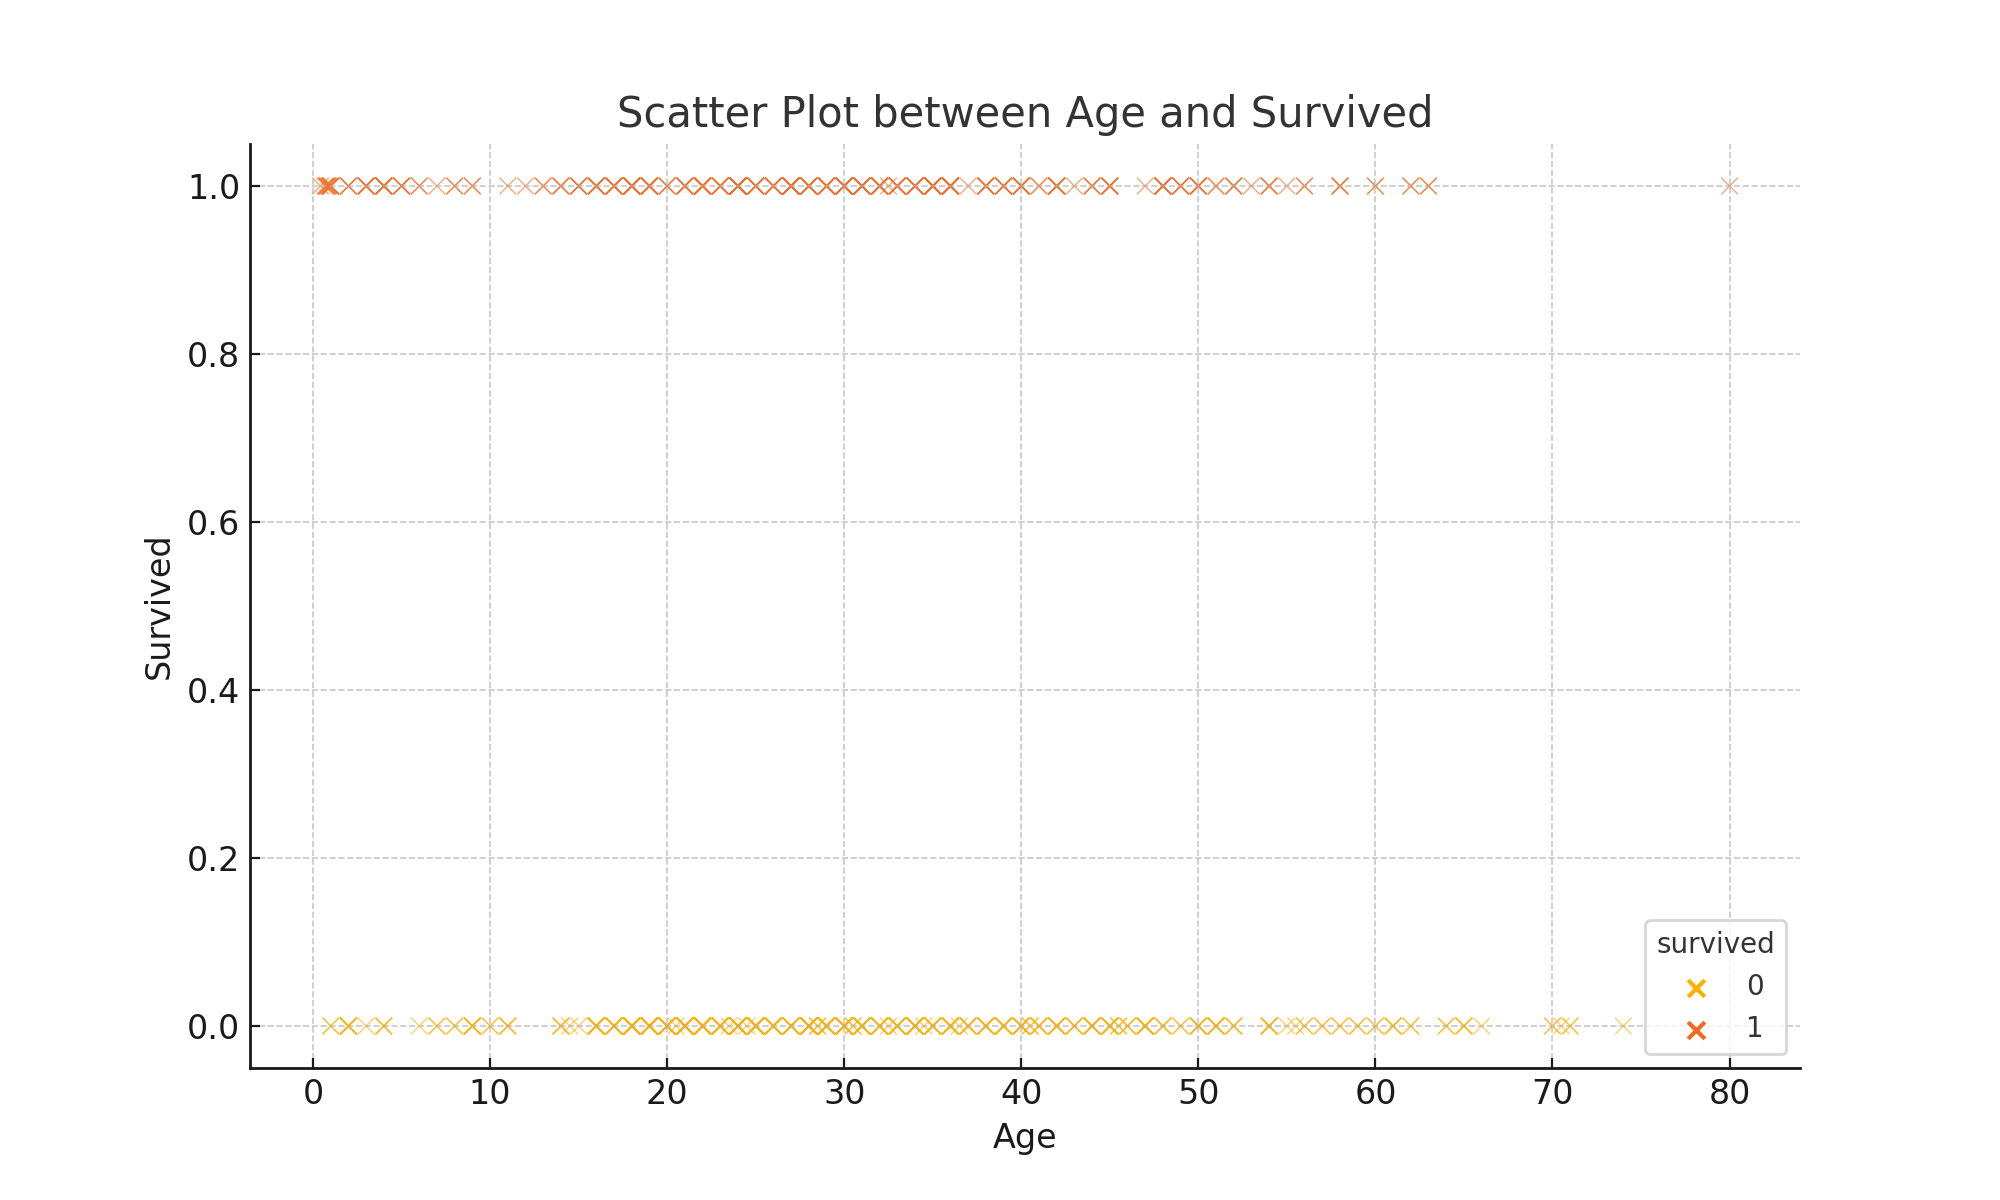

In [202]:
api_response = client.files.with_raw_response.retrieve_content(file_id="file-PWp1Vd52zoAJIM0YcQZV81Ub")
content = api_response.content
Image.open(io.BytesIO(base64.b64decode(io.BytesIO(content).read().decode('UTF-8'))))

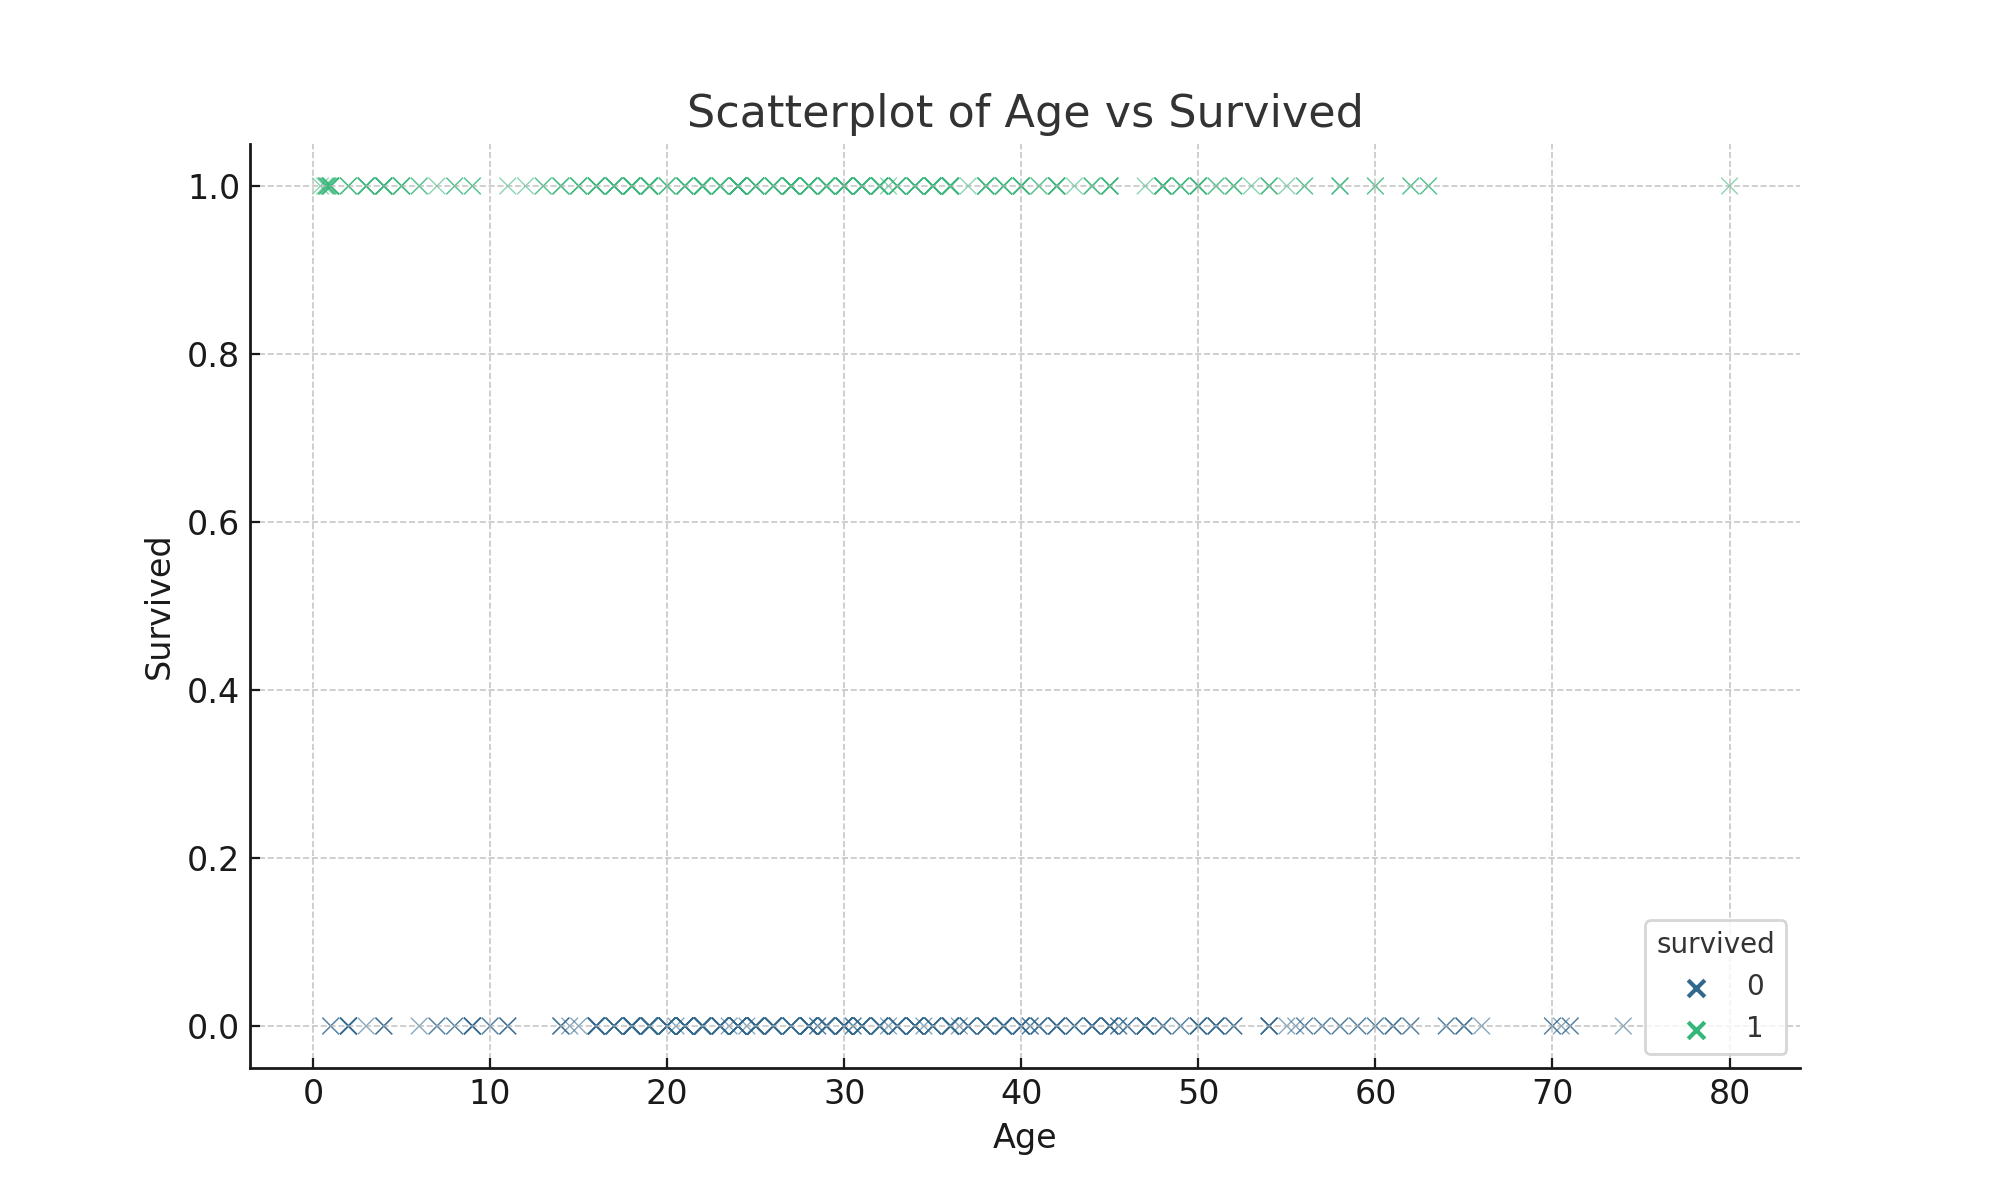

In [161]:
api_response = client.files.with_raw_response.retrieve_content(file_id="file-XOidw2vSZUpicmi6tzQNCulF")
content = api_response.content
image = Image.open(io.BytesIO(content))
display(image)

In [126]:
client.files.content(file_id=d.content[0].image_file.file_id)

NotFoundError: Error code: 404 - {'error': {'message': 'No such File object: file-tUwTYjS5M2nojbXbaFXqwAyh', 'type': 'invalid_request_error', 'param': 'id', 'code': None}}

In [119]:
file_id = 'file-8DC6zHhjGzRUD66usDOuv34r'
resp = client.files.with_raw_response.retrieve_content(file_id)

In [204]:
client.beta.threads.delete(thread_id=thread.id)
client.beta.assistants.delete(assistant_id=features_charts_painter.id)
client.files.delete(file_id=dataset_file.id)

FileDeleted(id='file-0SxPqf1EzFMHZ70hDA44T0tb', deleted=True, object='file')

In [205]:
for assist in client.beta.assistants.list().data:
    client.beta.assistants.delete(assistant_id=assist.id)

In [206]:
for file in client.files.list().data:
    client.files.delete(file_id=file.id)

In [82]:
show_json(features_charts_painter)

{'id': 'asst_tt3HkjXRtQmfPdENVUMF7fGt',
 'created_at': 1716497124,
 'description': None,
 'instructions': 'You are an excellent senior Data Scientist with 10 years of experience. You write and run code to describe connection between features and target, when you get table with data.',
 'metadata': {},
 'model': 'gpt-4-turbo',
 'name': 'Features charts painter',
 'object': 'assistant',
 'tools': [{'type': 'code_interpreter'}],
 'response_format': 'auto',
 'temperature': 1.0,
 'tool_resources': {'code_interpreter': {'file_ids': ['file-NlxDcmNsaRh7J0kVbJOiFC9z']},
  'file_search': None},
 'top_p': 1.0}

In [59]:
message = client.beta.threads.messages.create(
  thread_id=thread.id,
  role="user",
  content="I need to solve the equation `3x + 11 = 14`. Can you help me?"
)

In [60]:
assistant = client.beta.assistants.create(
  name="Math Tutor",
  instructions="You are a personal math tutor. Write and run code to answer math questions.",
  tools=[{"type": "code_interpreter"}],
  model="gpt-4o",
)

In [61]:
run = client.beta.threads.runs.create_and_poll(
  thread_id=thread.id,
  assistant_id=assistant.id,
  instructions="Please address the user as Jane Doe. The user has a premium account."
)

In [87]:
client.beta.assistants.delete(assistant_id=assistant.id)

AssistantDeleted(id='asst_iQzczi6vumXzHzJOblRB4kZw', deleted=True, object='assistant.deleted')